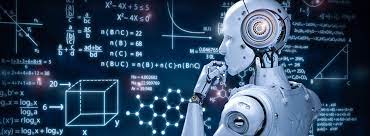

# 09 - Tópicos Avançados de Machine Learning II

Nessa aula, iremos tratar dos seguintes conteúdos:
- Escolha de Hiperparâmetros (tunagem de Modelos);
- Bases Desbalanceadas.

##   

## Escolha de Hiperparâmetros

Vamos ver na aula de hoje, como aprimorarmos os nosso modelo, onde já temos um modelo __baseline__ e uma __certa métrica__ com __boa performance__, mas vamos buscar refinar ainda mais a __escolha de parâmetros__ de forma a verificar se com outra combinações de parâmetros, se é possível __otimizar a performance do modelo__.<br><br>

### Entendendo os Hiperparâmetros

Antes de partimos para as técnicas de escolha de hiperparâmetros e otimização do nosso modelo, vamos começar entendendo que tipos de parâmetros temos disponíveis. No exemplo veremos os principais parâmetros de __modelos de Árvores__, mais especificamente no __RandomForest__:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier

In [2]:
model = RandomForestClassifier(random_state=42)

In [4]:
pprint("Parâmetros da RandomForest:")
pprint(model.get_params())

'Parâmetros da RandomForest:'
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Vamos enttender o significado dos parâmtetros que vamos mexer:

- __n_estimators__: São o número de árvores utilizada na floresta aleatória;
- __criterion__: O Critério de cálculo para a separação dos nós (onde vimos o 'gini' e a 'entropy');
- __max_depth__: Profundidade máxima da árvore;
- __min_samples_split__: Quantidade mínima de dados em um nó antes da separação nas folhas;
- __min_samples_leaf__: Quantidade mínima de dados em uma folha após a separação.

##   

## Técnicas de Otimização

Hoje iremos trabalhar com duas técnicas de otimização de modelos bem conhecidas e largamente utilizadas que são o __GridSearchCV__ e o __RandomizedSearchCV__:

### GridsearchCV

O GridSearchCV é uma técnica onde determinado os parâmetros que queremos testar no nosso modelo, ele vai __testar todas as combinações de cada um dos parâmetros__ e realizar um __Cross Validation__ para cada combinações e calcular uma dada métrica. A combinação que apresentar o __melhor desempenho da métrica__ será a __combinação otimizada__ para o nosso modelo <br><br>

__Importante!:__ Perceba que treinar __todas as combinações possíveis__ vai decorrer de um custo computacional muito alto, dessa forma apesar de ser a técnica mais utilizada, não é a melhor técnica a ser aplicada.

### RandomizedSearchCV

A ideia por trás do RandomizedSearchCV é análoga ao GridSearchCV, mas ao invés de testar todas as combinações de parâmetros, o RandomizedSearchCV testa __algumas combinações aleatórias dos parâmetros__, onde definimos a quantidade de iterações desse processo ele irá processar. A partir das combinações, o RandomizedSearchCV realiza o mesmo processo do GridSearchCV, faz o __Cross Validation__ e __calcula a métrica de acompanhamento__, por fim defini qual a melhor combinação de parâmetros.

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-05318-5_1/MediaObjects/453309_1_En_1_Fig1_HTML.png" width=800>

Vamos voltar no exercício para a qualidade do vinho tinto no dataset _winequality-red.csv_:

In [5]:
wine = pd.read_csv('./datasets/winequality-red.csv')
wine.head()

FileNotFoundError: ignored

In [ ]:
wine['target'] = np.where(wine['quality'] > 5, 1, 0)

In [ ]:
X = wine.drop(['quality', 'target'], axis = 1)

In [ ]:
X.head()

In [ ]:
y = wine['target']

In [ ]:
y.value_counts(normalize = True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify = y)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

In [ ]:
acc = accuracy_score(y_test, y_pred)

Para fazermos tanto o __GridSearchCV__ quanto o __RandomizedSearchCV__ vamos definir os __parâmetros__ que vamos variar e para quais valores vamos testar:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(params_grid)

__Obs.:__ Lembrando que o __GridSearchCV__ vai testar todas as combinações, ou seja teremos 6 x 3 x 3 x 5 = 270 combinações de parâmetros! Além da quantidade de splits (__cv__) que precisamos passar para o __Cross Validation__. Por isso é muito fácil escalonar rápidamente o custo computacional do nosso modelo!

Aplicando primeiramente o GridSearchCV:

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = params_grid, 
                           scoring='accuracy', 
                           cv = 3, 
                           verbose = 2,
                           n_jobs = -1)

In [ ]:
%%time

grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.cv_results_['mean_test_score'].mean())

In [ ]:
grid_search.best_params_

In [ ]:
# Lista de combinações de parâmetros
cvs = pd.DataFrame(grid_search.cv_results_)
display(cvs)

In [ ]:
model_gs = RandomForestClassifier(max_depth = 32,
                                  min_samples_leaf = 1,
                                  min_samples_split = 5,
                                  n_estimators = 100,
                                  random_state = 42)

In [ ]:
model_gs.fit(X_train, y_train)

In [ ]:
y_pred_gs = model_gs.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred_gs))

In [ ]:
acc_grid = accuracy_score(y_test, y_pred_gs)

Aplicando agora o __RandomizedSearchCV__:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = RandomForestClassifier(random_state = 42)

In [ ]:
random_search = RandomizedSearchCV(estimator = model, 
                                   param_distributions = params_grid, 
                                   n_iter = 100, 
                                   cv = 3, 
                                   verbose=2,
                                   n_jobs = -1)

In [ ]:
%%time

random_search.fit(X_train, y_train)

In [ ]:
print(random_search.cv_results_['mean_test_score'].mean())

In [ ]:
random_search.best_params_

In [ ]:
model_rs = RandomForestClassifier(max_depth = 32,
                                  min_samples_leaf = 2,
                                  min_samples_split = 2,
                                  n_estimators = 1100,
                                  random_state = 42)

In [ ]:
model_rs.fit(X_train, y_train)

In [ ]:
y_pred_rs = model_rs.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred_rs))

In [ ]:
acc_random = accuracy_score(y_test, y_pred_rs)

In [ ]:
print("Comparação das Acurácias: ")
print('Acurácia sem Otimização:         ', np.round(acc, 3))
print('Acurácia com GridSearchCV:       ', np.round(acc_grid, 3))
print('Acurácia com RandomizedSearchCV: ', np.round(acc_random, 3))

##   

## Dados Desbalanceados

Um dos problemas mais comum quando trabalhamos com predição de dados é quando trabalhamos como __classes desbalanceadas!__ Tentamos prever uma classe minoritária, a predição pode ficar até boa, mas quando comparado com o caso de classificarmos os dados como todos da classe majoritária, __não haveria tanta diferença na predição do resultado__. Vamos ao exemplo de fixação:<br><br>
Imagine um dataset sobre transações fraudulentas, onde 1% das transações são fraudes e 99% não fraudelentas:<br>
- Desenvolvemos um __modelo__ é a __acurácia__ dele deu __90%__, ou seja a cada 100 transações ele acerta que 90 delas não;
- Agora se eu chutasse que __todas as transações não fosse fraudulentas__, quanto ficaria a acurácia? Sabendo da proporção da base de 99/1, se falar que todas não são fraudulentas, vamos acertar 99 transações a cada 100, ou seja __99% de acurácia__;<br><br>

Esse tipo de problema é bem comum em bases desbalanceadas e precisamos saber como evitar isso!<br><br>
Hoje vamos ver 3 técnicas pra lidar com desbalanceamento de dados sendo eles: __Undersampling__, __Oversampling__ e o __SMOTE__.

##   

### Undersampling e Oversampling

Tanto o __Undersampling__ quanto o __Oversampling__ são técnicas simples de lidar com dados desbalanceados e focam basicamente em __remoção__ ou __adição__ de dados no nosso dataset:

<img src="https://miro.medium.com/max/725/1*7xf9e1EaoK5n05izIFBouA.png" width=800>

> No caso do __Undersampling__, remove dados aleatoriamente da classe majoritária do dataset até atingir uma proporção de 50/50 dos dados (até atingir a mesma quantidade de ambas as classes

No caso do __Undersampling__ podemos ter problemas de aplicações quando o nosso dataset têm __poucos dados__, pois perdemos muito dados que podem ter informações úteis para o modelo.

> No __Oversampling__, vai adicionar dados, duplicando informações da classe minoritária até termos as mesmas proporções de dados também

O lado contra de aplicarmos o __Oversampling__ é que perdemos com a __variabilidade dos dados__ da classe minoritária, no caso só estamos replicando os mesmos dados.<br><br>

Vamos testar na prática, começando pelo __Oversampling__:

In [ ]:
! pip install imbalanced-learn
! pip install delayed

In [ ]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
wine = pd.read_csv('./datasets/winequality-red.csv')
wine.head()

In [ ]:
wine['target'] = np.where(wine['quality'] > 6.5, 1, 0)

In [ ]:
X = wine.drop(['quality', 'target'], axis = 1)

In [ ]:
X.head()

In [ ]:
y = wine['target']

In [ ]:
y.value_counts(normalize = True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.4, 
                                                    random_state=42,
                                                    stratify = y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state = 42)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc_normal = accuracy_score(y_test, y_pred)
acc_normal

Aplicando o _OverSampling_:

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [ ]:
X_train_ov, y_train_ov = oversample.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
y_train_ov.value_counts()

In [ ]:
model.fit(X_train_ov, y_train_ov)

In [ ]:
y_pred_ov = model.predict(X_test)

In [ ]:
acc_over = accuracy_score(y_test, y_pred_ov)
acc_over

Utilizando o __Undersampling__:

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
X_train_un, y_train_un = undersample.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
y_train_un.value_counts()

In [ ]:
model.fit(X_train_un, y_train_un)

In [ ]:
y_pred_un = model.predict(X_test)

In [ ]:
acc_under = accuracy_score(y_test, y_pred_un)

In [ ]:
print("Comparação das Acurácias: ")
print('Acurácia sem Tratamento:    ', np.round(acc_normal, 3))
print('Acurácia com Oversampling:  ', np.round(acc_over, 3))
print('Acurácia com Undersampling: ', np.round(acc_under, 3))

##   

### SMOTE

O __SMOTE__ (Synthetic Minority Oversampling Technique) é uma técnica um pouco mais sofisticada que o __Oversampling__, onde está técnica foca em corrigir o problema que tinhamos no Oversampling de __variabilidade de dados__.<br><br>

<img src="https://miro.medium.com/max/1400/1*GJY7UnJ4WCzqgtrfkCvkdA.png" width=800> 

O princípio do SMOTE é gerar amostras para a classe minoritária criando pontos artificiais que sejam vizinhos da classe, de maneira a garantir que tenha __variabilidade dos dados__ e __que todos os pontos sejam da classe minoritária__.<br><br>
Vamos testar a aplicação do SMOTE:

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
y_train_sm.value_counts()

In [ ]:
model = RandomForestClassifier(random_state = 42)

In [ ]:
model.fit(X_train_sm, y_train_sm)

In [ ]:
y_pred_sm = model.predict(X_test)

In [ ]:
acc_smote = accuracy_score(y_test, y_pred_sm)

In [ ]:
print("Comparação das Acurácias: ")
print('Acurácia sem Tratamento:    ', np.round(acc_normal, 3))
print('Acurácia com Oversampling:  ', np.round(acc_over, 3))
print('Acurácia com Undersampling: ', np.round(acc_under, 3))
print('Acurácia com SMOTE:         ', np.round(acc_smote, 3))

In [ ]:
from sklearn.metrics import classification_report

print('Sem tratamento')
print(classification_report(y_test, y_pred))
print('\nOversampling')
print(classification_report(y_test, y_pred_ov))
print('\nUndersampling')
print(classification_report(y_test, y_pred_un))
print('\nSMOTE')
print(classification_report(y_test, y_pred_sm))

##   

## Exercícios

**1)** Realize uma classificação com da coluna y dos dados de marketing bancário (contido no arquivo bank-full.csv). Utiliza as 3 técnicas para dados desbalanceados para melhorar o desempenho do modelo (podem usar o RandomForest). Qual a melhor técnica de balanceamento para esses dados?

##   